In [1]:
# 连接上谷歌云盘
from google.colab import drive 
drive.mount('/content/drive')
!pwd

import os
os.chdir('drive/My Drive/5003project')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content
/content/drive/My Drive/5003project


In [0]:
import pandas as pd
import numpy as np
import time

In [0]:
rent_file = 'renttherunway_final_data.json'
rent_df = pd.read_json(rent_file, lines=True)

In [0]:
ratings = rent_df[['user_id', 'item_id', 'rating']]
ratings = ratings.drop_duplicates()
ratings = ratings.dropna()
items = rent_df[['item_id', 'category']]
items = items.drop_duplicates()
items = items.dropna()

In [0]:
ratings.to_csv('ratings.csv', index=0)
items.to_csv('items.csv', index=0)

In [9]:
# 安装pyspark
! pip install pyspark

    100% |████████████████████████████████| 193.9MB 133kB/s 
    100% |████████████████████████████████| 204kB 29.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/dc/0e/02/e9fdf0bf3ad20284175307d4ab31afcf967604f25f3b4f1d96
Successfully built pyspark


In [0]:
# 构建RDD环境
from pyspark import SparkConf
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf())

# 构建Spark SQL 环境
from pyspark.sql import SparkSession
from pyspark.sql import Row
spark = SparkSession \
        .builder \
        .appName("RDD_and_DataFrame") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [0]:
# read the data
items_file_name = 'items.csv'
ratings_file_name = 'ratings.csv'

items = spark.read.csv(movies_file_name, header=True, inferSchema=True).repartition(10).cache()
ratings = spark.read.csv(ratings_file_name, header=True, inferSchema=True).repartition(10).cache()

In [17]:
items.printSchema()
ratings.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- category: string (nullable = true)

root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: double (nullable = true)



In [18]:
# Run the describe() method to see the count, mean, standard deviation, minimum, and maximum values 
# for the data in each column:
ratings.describe().show()

+-------+-----------------+------------------+------------------+
|summary|          user_id|           item_id|            rating|
+-------+-----------------+------------------+------------------+
|  count|           192202|            192202|            192202|
|   mean|499470.4077949241|1045612.1130165139| 9.092132235876837|
| stddev|289064.0776498484|  805537.221596533|1.4302377439066392|
|    min|                9|            123373|               2.0|
|    max|           999997|           2966087|              10.0|
+-------+-----------------+------------------+------------------+



In [20]:
# use specific methods from the DataFrame API to compute any statistic:
print("Number of different users: " + str(ratings.select('user_id').distinct().count()))
print("Number of different items: " + str(ratings.select('item_id').distinct().count()))
print("Number of items with at least one rating strictly higher than 4: " + str(ratings.filter('rating > 4').select('item_id').distinct().count()))

Number of different users: 105508
Number of different items: 5850
Number of items with at least one rating strictly higher than 4: 5840


In [21]:
# Find the number of items with ratings higher than 4 again, this time with SQL:
ratings.createOrReplaceTempView('ratings')
spark.sql("SELECT COUNT(DISTINCT(item_id)) AS nb FROM ratings WHERE rating > 4").show()

+----+
|  nb|
+----+
|5840|
+----+



In [22]:
# switch between Spark distributed DataFrames and pandas local DataFrames.
import pandas as pd

ratings.toPandas().head()

,user_id,item_id,rating
0,356134,227442,10.0
1,657574,729362,8.0
2,384754,755371,10.0
3,680543,341450,10.0
4,176679,126335,10.0


In [23]:
# Visualize the data
!pip install seaborn

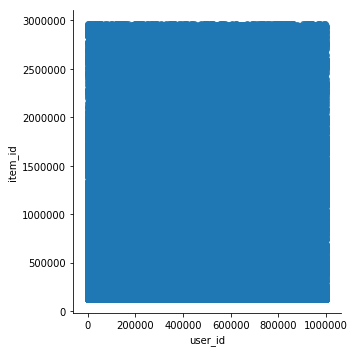

In [24]:
# Create a graph of the items reviewed by users:
import seaborn as sns
%matplotlib inline

ratingsPandas = ratings.toPandas()
sns.lmplot(x='user_id', y='item_id', data=ratingsPandas, fit_reg=False)

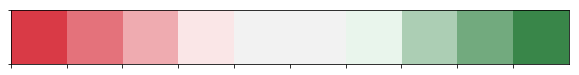

In [25]:
# This matrix represents all the items rated by users, but doesn't distinguish the ratings. 
# Improve the graph by choosing a color palette to color the ratings:
sns.palplot(sns.diverging_palette(10, 133, sep=80, n=10))

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


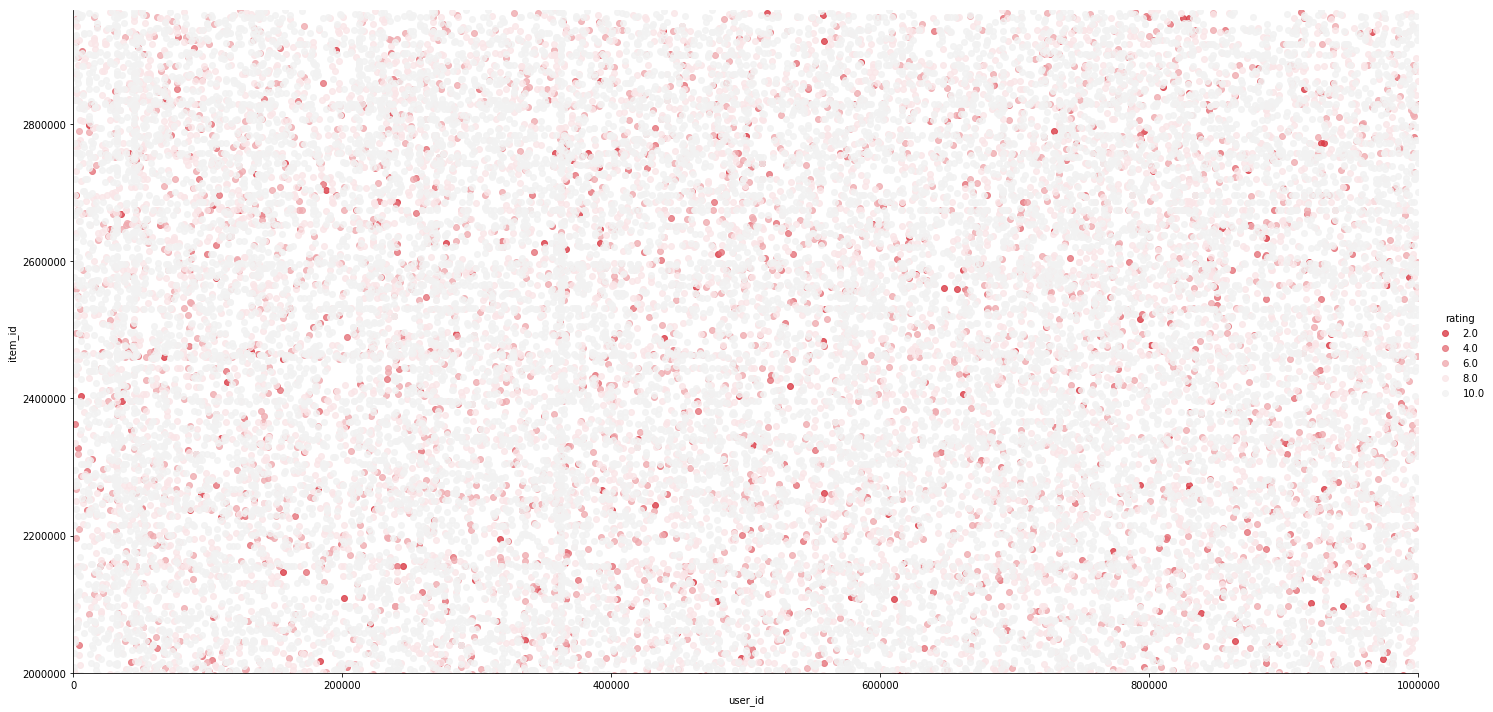

In [27]:
# Create the graph on a larger scale with the color palette:
lm = sns.lmplot(x='user_id', y='item_id', hue='rating', data=ratingsPandas, fit_reg=False, size=10, aspect=2, palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0,0].set_ylim(2000000,2966087) # max movieId is 163949
axes[0,0].set_xlim(9,999997) # max userId is 999997
lm

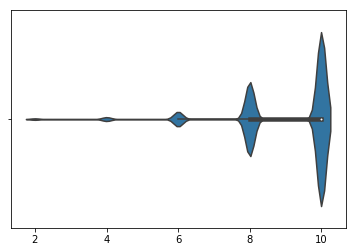

In [28]:
sns.violinplot([ratingsPandas.rating])